In [5]:
import os

# Set datapath properly
path = os.getcwd() + "/data/"

if not os.path.exists(path):
  os.makedirs(path)

%env DATAPATH={path}

raw = 's.rsf'
raw_hfile = 's_hfile.rsf'
raw_tfile = 's_tfile.txt'
raw_bfile = 's_bfile.txt'
raw_deghost = "s_deghost.rsf"
raw_deghost_cdp = 's_deghost_cdp.rsf'
raw_deghost_gain = "s_deghost_gain.rsf"
raw_deghost_gain_cdp = "s_deghost_gain_cdp.rsf"
raw_deghost_gain_mute = "s_deghost_gain_mute.rsf"
raw_deghost_gain_mute_cdp = "s_deghost_gain_mute_cdp.rsf"
raw_deghost_gain_mute_dip = "s_deghost_gain_mute_dip.rsf"
raw_deghost_gain_mute_dip_cdp = "s_deghost_gain_mute_dip_cdp.rsf"
raw_deghost_gain_mute_dip_radon_cdp = "s_deghost_gain_mute_dip_radon_cdp.rsf"
vnmo_rsf = 'vnmo.rsf'
vnmow_rsf = 'vnmow.rsf'
sample = 'sample.rsf'
sample_deghost = 'sample_deghost.rsf'
sample_deghost_gain = 'sample_deghost_gain.rsf'
sample_deghost_gain_mute = 'sample_deghost_gain_mute.rsf'
sample_deghost_gain_mute_cdp = 'sample_deghost_gain_mute_cdp.rsf'
sample_deghost_gain_mute_dip = 'sample_deghost_gain_mute_dip.rsf'
sample_deghost_gain_mute_dip_cdp = 'sample_deghost_gain_mute_dip_cdp.rsf'
header_complete = 'sp_header_complete.rsf'
header_complete_int = 'sp_header_complete_int.rsf'
cdp_offsets = 'cdp_offsets.rsf'
sample_offsets = 'sample_cdp_offsets.rsf'
cdp_mask = "cdp_mask.rsf"
wavelet_file = "FarField.dat"

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from rsf.proj import *
import rsf.api as sf
import m8r
from m8r import view
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import periodogram, welch
from wiggle.wiggle import wiggle
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf

env: DATAPATH=/mnt/HDD_2TB/VikingGraben/line12/proc_rsf/data/


Extract CDP sample

In [2]:
sample_deghost_gain_mute_dip_radon_cdp = 'sample_deghost_gain_mute_dip_radon_cdp.rsf'

cdp = 1000
!sfwindow f3={cdp} n3=1 < {raw_deghost_gain_mute_dip_radon_cdp} > {sample_deghost_gain_mute_dip_radon_cdp}
!sfintbin < {header_complete} head={header_complete_int} yk=cdp xk=cdpt | \
    sfwindow f3={cdp} n3=1 | \
    sfheadermath output='offset'/1000. > {sample_offsets}

sfintbin: 2142 of 2142;


Compare VelScans

sfvscan: cmp 1 of 1;
sfvscan: cmp 1 of 1;
sfpick: cmp 1 of 1;
sfpick: iteration 0 res: 1.000000 grad: 0.000000
sfpick: iteration 1 res: 0.517956 grad: 0.180019
sfpick: iteration 2 res: 0.322049 grad: 0.055061
sfpick: iteration 3 res: 0.189943 grad: 0.036097
sfpick: iteration 4 res: 0.098469 grad: 0.017670
sfpick: iteration 5 res: 0.058003 grad: 0.008050
sfpick: iteration 6 res: 0.035241 grad: 0.011199
sfpick: iteration 7 res: 0.026064 grad: 0.011528
sfpick: iteration 8 res: 0.016924 grad: 0.004611
sfpick: iteration 9 res: 0.009568 grad: 0.002788
sfpick: iteration 10 res: 0.004681 grad: 0.001102
sfpick: iteration 11 res: 0.002654 grad: 0.000456
sfpick: iteration 12 res: 0.002283 grad: 0.001440
sfpick: iteration 13 res: 0.001739 grad: 0.000294
sfpick: iteration 14 res: 0.001461 grad: 0.000452
sfpick: iteration 15 res: 0.000988 grad: 0.000152
sfpick: iteration 16 res: 0.000600 grad: 0.000158
sfpick: iteration 17 res: 0.000456 grad: 0.000081
sfpick: iteration 18 res: 0.000307 grad: 0.00009

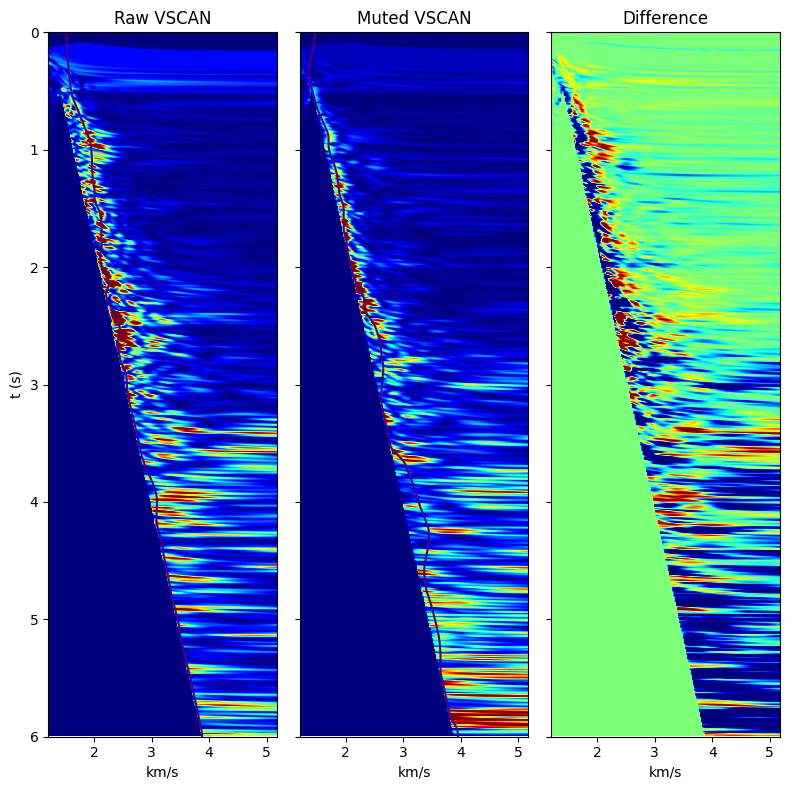

In [7]:
sample_vscan = "sample_deghost_gain_mute_dip_cdp_vscan.rsf"
sample_dip_vscan = "sample_deghost_gain_mute_dip_radon_cdp_vscan.rsf"

raw=sample_vscan
proc=sample_dip_vscan
raw_picks="sample_picks.rsf"
proc_picks="sample_picks_dip.rsf"

v0=1.2
dv=0.02
nv=200
nb=2
mute_x0=1.4
mute_v0=0.45
mute_t0=0.5
!sfvscan < {sample_deghost_gain_mute_dip_cdp} offset={sample_offsets} nb={nb} v0={v0} dv={dv} nv={nv} semblance=y half=n |\
    sfmutter inner=y x0={mute_x0} v0={mute_v0} t0={mute_t0} half=n > {raw}
!sfvscan < {sample_deghost_gain_mute_dip_radon_cdp} offset={sample_offsets} nb={nb} v0={v0} dv={dv} nv={nv} semblance=y half=n |\
    sfmutter inner=y x0={mute_x0} v0={mute_v0} t0={mute_t0} half=n > {proc}

rect1=15
rect2=5
vel0=1.5
!sfpick < {raw} rect1={rect1} rect2={rect2} vel0={vel0} back=y > {raw_picks}
!sfpick < {proc} rect1={rect1} rect2={rect2} vel0={vel0} back=y > {proc_picks}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))
raw_picks_arr = np.array(sf.Input(raw_picks))
proc_picks_arr = np.array(sf.Input(proc_picks))
picks_list = [raw_picks_arr, proc_picks_arr]

t = np.arange(raw_arr.shape[1]) * d1
titles = ["Raw VSCAN", "Muted VSCAN", "Difference"]
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [v0, v0+dv*(nv-1), t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='jet')
    if i == 0:
        plt.ylabel('t (s)')
    if i < 2:
        plt.plot(picks_list[i],t, color="Indigo")
    plt.xlabel('km/s')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Calculate picks for the whole dataset

In [8]:
vnmo_auto_rsf = "vnmo_auto.rsf"

!sfvscan < {raw_deghost_gain_mute_dip_radon_cdp} offset={cdp_offsets} \
  nb={nb} v0={v0} dv={dv} nv={nv} semblance=y half=n |\
  sfmutter inner=y x0={mute_x0} v0={mute_v0} t0={mute_t0} half=n |\
  sfpick rect1={rect1} rect1={rect2} back=y > {vnmo_auto_rsf}

sfpick: cmp 2142 of 2142;;

sfpick: iteration 0 res: 0.997605 grad: 0.000000
sfpick: iteration 1 res: 0.421885 grad: 0.405104
sfpick: iteration 2 res: 0.226293 grad: 0.177665
sfpick: iteration 3 res: 0.133932 grad: 0.093017
sfpick: iteration 4 res: 0.084615 grad: 0.054484
sfpick: iteration 5 res: 0.056095 grad: 0.035410
sfpick: iteration 6 res: 0.038370 grad: 0.023367
sfpick: iteration 7 res: 0.027042 grad: 0.016490
sfpick: iteration 8 res: 0.019542 grad: 0.011631
sfpick: iteration 9 res: 0.014467 grad: 0.008545
sfpick: iteration 10 res: 0.010919 grad: 0.006337
sfpick: iteration 11 res: 0.008379 grad: 0.004816
sfpick: iteration 12 res: 0.006521 grad: 0.003691
sfpick: iteration 13 res: 0.005129 grad: 0.002788
sfpick: iteration 14 res: 0.004047 grad: 0.002124
sfpick: iteration 15 res: 0.003226 grad: 0.001667
sfpick: iteration 16 res: 0.002601 grad: 0.001310
sfpick: iteration 17 res: 0.002110 grad: 0.001059
sfpick: iteration 18 res: 0.001726 grad: 0.000839
sfpick: iteration 19 res: 0.0014

Smooth auto picked velocity model

In [9]:
vnmo_auto_smooth_rsf = "vnmo_auto_smooth.rsf"
!sfsmooth < {vnmo_auto_rsf} rect1=1 rect2=50 repeat=3 > {vnmo_auto_smooth_rsf}

Visualize calculated Vel Model

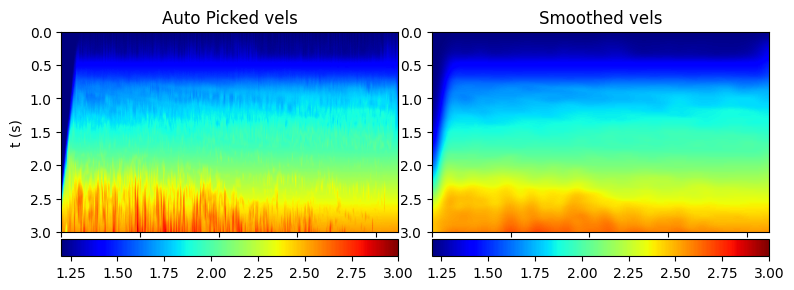

In [10]:
raw_stack = vnmo_auto_rsf
proc_stack = vnmo_auto_smooth_rsf

# Load vel models and visualize them
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

plt.figure(figsize=(8,3))
v_titles = ["Auto Picked vels", "Smoothed vels"]
for i, data in enumerate([raw_stack_arr, proc_stack__arr]):
    plt.subplot(1,2, i+1)
    extent = [0, data.shape[0], t[-1], t[0]]

    im=plt.imshow(data.T, aspect='auto', extent=extent,
              cmap='jet')
    plt.clim(1.2,3)
    plt.colorbar(im, orientation="horizontal", pad=0.03)
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')

    plt.title(v_titles[i])
    plt.ylim(3,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Compare stacks

sfnmo: CMP 2142 of 2142;
sfnmo: CMP 2142 of 2142;


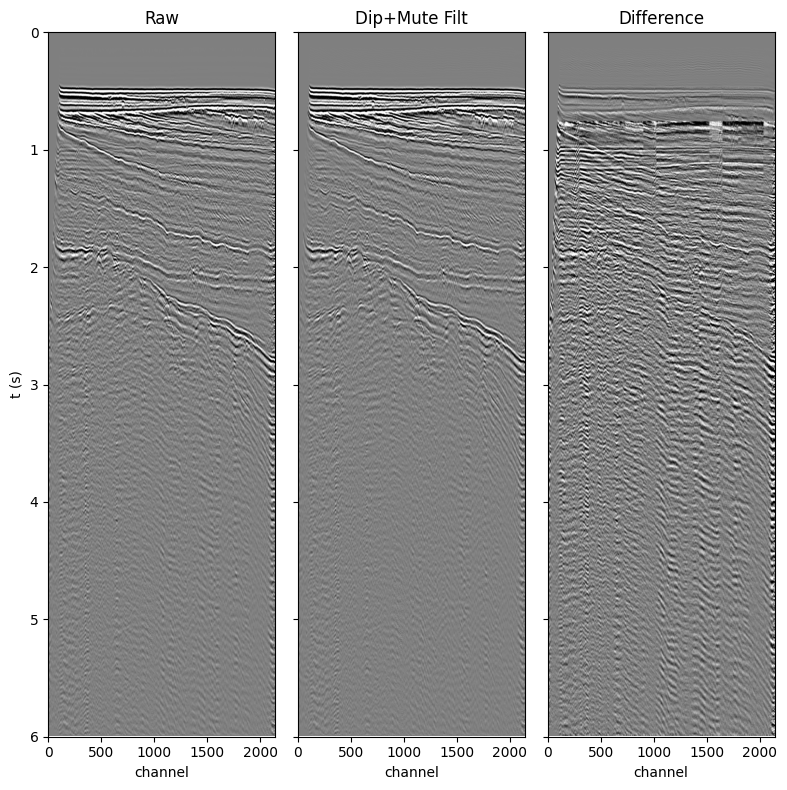

In [11]:
raw = raw_deghost_gain_mute_dip_cdp
proc = raw_deghost_gain_mute_dip_radon_cdp

raw_stack = 's_deghost_gain_mute_dip_cdp_stk.rsf'
proc_stack = 's_deghost_gain_mute_dip_radon_cdp_stk.rsf'

!sfnmo < {raw} velocity={vnmo_auto_smooth_rsf} offset={cdp_offsets} half=n | \
    sfstack > {raw_stack}

!sfnmo < {proc} velocity={vnmo_auto_smooth_rsf} offset={cdp_offsets} half=n | \
    sfstack > {proc_stack}

# Load stacks and visualize it
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

titles = ["Raw", "Dip+Mute Filt", "Difference"]
plt.figure(figsize=(8, 8))
for i, data in enumerate([raw_stack_arr, proc_stack__arr, raw_stack_arr-proc_stack__arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]

    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')

    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)